In [1]:
!pip install transformers datasets torch pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import os
import pandas as pd
import torch
from transformers import BertTokenizerFast, BertForQuestionAnswering, Trainer, TrainingArguments, get_scheduler, EarlyStoppingCallback
from datasets import Dataset, load_metric, DatasetDict
from transformers import default_data_collator
import matplotlib.pyplot as plt

In [3]:
# Verify GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Clear GPU memory
if device == 'cuda':
    torch.cuda.empty_cache()


Using device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the data from Excel
folder_path = f'/content/drive/My Drive/Additional Education/NJIT/Classes/DS677-850 Deep Learning/Project/Work Data'

synthetic_data_path = f"{folder_path}/labeled_synthetic_data (specific questions and answers).xlsx"
qa_df = pd.read_excel(synthetic_data_path)

# Ensure the necessary columns are present
qa_df = qa_df[['Question', 'Answer', 'LongText']]

In [7]:
# Create a Dataset object
dataset = Dataset.from_pandas(qa_df)

# Split the dataset into train and test sets
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [8]:
# Load tokenizer and model
# Larger model
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Smaller models
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# Move model to GPU
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [9]:
# Freeze the first 12 layers
for param in model.bert.encoder.layer[:12].parameters():
    param.requires_grad = False

In [10]:
# Define the preprocess function
def preprocess_function(examples):
    tokenized_inputs = tokenizer(
        examples['LongText'],
        max_length=512,
        truncation=True,
        padding='max_length',
        return_offsets_mapping=True
    )

    # Tokenize the answer separately to find its token positions
    start_positions = []
    end_positions = []
    for i in range(len(examples['LongText'])):
        context = examples['LongText'][i]
        answer = examples['Answer'][i]

        answer_start_char = context.find(answer)
        answer_end_char = answer_start_char + len(answer)

        start_token_idx = None
        end_token_idx = None

        for idx, (start, end) in enumerate(tokenized_inputs['offset_mapping'][i]):
            if start <= answer_start_char < end:
                start_token_idx = idx
            if start < answer_end_char <= end:
                end_token_idx = idx
                break

        start_positions.append(start_token_idx if start_token_idx is not None else 0)
        end_positions.append(end_token_idx if end_token_idx is not None else 0)

    tokenized_inputs['start_positions'] = start_positions
    tokenized_inputs['end_positions'] = end_positions
    return tokenized_inputs


In [11]:
# Test the preprocess function on a small sample
sample = dataset.select(range(3))
tokenized_sample = sample.map(preprocess_function, batched=True)

# Verify the tokenized sample
for i in range(len(tokenized_sample)):
    example = tokenized_sample[i]
    start_position = example['start_positions']
    end_position = example['end_positions']
    input_ids = example['input_ids']

    # Decode the tokenized input IDs
    decoded_input = tokenizer.decode(input_ids)
    # Extract the tokens corresponding to the start and end positions
    answer_tokens = input_ids[start_position:end_position + 1]
    decoded_answer = tokenizer.decode(answer_tokens)

    print(f"Example {i + 1}:")
    print(f"Question: {sample[i]['Question']}")
    print(f"Context: {sample[i]['LongText']}")
    print(f"Answer: {sample[i]['Answer']}")
    print(f"Tokenized Input IDs: {input_ids}")
    print(f"Start Position: {start_position}, End Position: {end_position}")
    print(f"Offsets: {example['offset_mapping']}")
    print(f"Decoded Context: {decoded_input}")
    print(f"Extracted Answer: {decoded_answer}")
    print("\n")

    # Check if the extracted answer matches the original answer
    original_answer = sample[i]['Answer']
    if original_answer.strip().lower() == decoded_answer.strip().lower():
        print("The extracted answer matches the original answer.")
    else:
        print("The extracted answer does not match the original answer.")
        # Provide more detailed comparison
        print(f"Original Answer: {original_answer.strip()}")
        print(f"Extracted Answer: {decoded_answer.strip()}")
    print("\n")

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Example 1:
Question: What immediate actions were recommended following the discovery of abnormally low pressure in the 18B Pump?
Context: * **************Incident Description************** * Notification 000030761040 Details * *********************************************************** * 03/15/2019 15:26:32 INCIDENT REPORT (INCIDENT REPORT) * Report submitted by: James Franklin ENTITY\INCIDENT: * * CONDITION DESCRIPTION/LOCATION (THE INAPPROPRIATE ACTION AND ITS NEGATIVE EFFECT/INCLUDE A DETAILED LOCATION DESCRIPTION): * During regular inspection on 03/15/2019, 18B Pump was found operating at a significantly lower pressure than usual. Initial measurement showed 34 psig, which is lower than the average operating pressure of the pump. All necessary pressure checks were made  and potential leak points inspected. Noise and heat generation appear to be in normal range, but the decreased pressure could indicate an internal compromise in the pump or a problem in the supply line. * * ACTIVITIE

In [12]:
# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)


Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,  # Increased learning rate
    per_device_train_batch_size=10, # 10 is the highest batch my GPU can handle
    per_device_eval_batch_size=10,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=1,  # Adjust if you use a smaller batch size
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# Data collator
data_collator = default_data_collator

In [15]:
# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)

# Define a dynamic learning rate scheduler
num_train_steps = len(tokenized_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)


In [16]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    optimizers=(optimizer, lr_scheduler),
    callbacks=[early_stopping_callback],
)

In [17]:
# Add the learning rate scheduler to the Trainer
trainer.lr_scheduler = lr_scheduler

# Fine-tune the model
train_result = trainer.train()

Epoch,Training Loss,Validation Loss
1,7.822700,7.514891
2,7.710500,7.428365
3,7.309900,7.345096
4,7.241900,7.265758
5,6.992700,7.187813
6,7.383500,7.112850
7,7.300300,7.040092
8,6.729400,6.972361
9,7.202300,6.911715
10,7.144700,6.855649


In [18]:
# Evaluate the model
eval_results = trainer.evaluate()

In [19]:
# Save the model
model.save_pretrained(f'{folder_path}/fine_tuned_bert_model')
tokenizer.save_pretrained(f'{folder_path}/fine_tuned_bert_model')

('/content/drive/My Drive/Additional Education/NJIT/Classes/DS677-850 Deep Learning/Project/Work Data/fine_tuned_bert_model/tokenizer_config.json',
 '/content/drive/My Drive/Additional Education/NJIT/Classes/DS677-850 Deep Learning/Project/Work Data/fine_tuned_bert_model/special_tokens_map.json',
 '/content/drive/My Drive/Additional Education/NJIT/Classes/DS677-850 Deep Learning/Project/Work Data/fine_tuned_bert_model/vocab.txt',
 '/content/drive/My Drive/Additional Education/NJIT/Classes/DS677-850 Deep Learning/Project/Work Data/fine_tuned_bert_model/added_tokens.json',
 '/content/drive/My Drive/Additional Education/NJIT/Classes/DS677-850 Deep Learning/Project/Work Data/fine_tuned_bert_model/tokenizer.json')

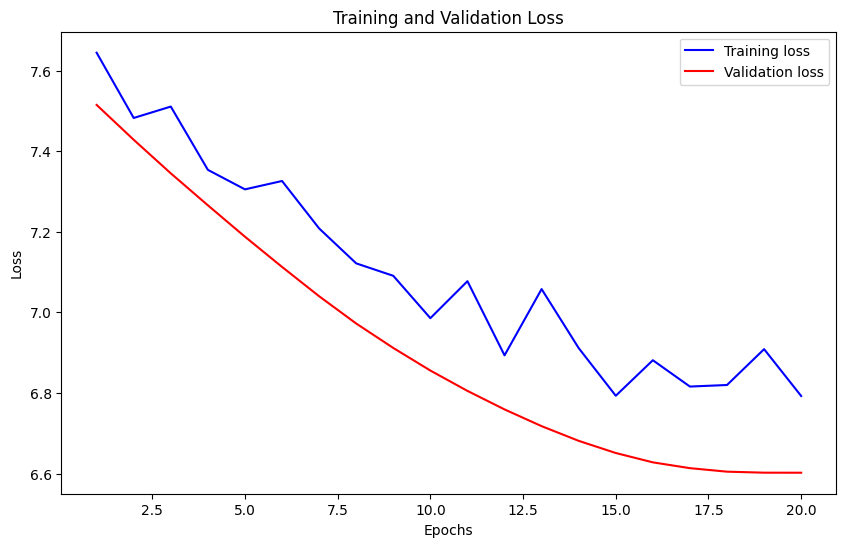

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training and evaluation loss from the log history
log_history = trainer.state.log_history

# Initialize lists for storing losses and epochs
train_loss_per_step = []
eval_loss_per_epoch = []
steps = []
eval_epochs = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_step.append(log['loss'])
        steps.append(log['epoch'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss_per_epoch.append(log['eval_loss'])
        eval_epochs.append(log['epoch'])

# Normalize the training loss to match the number of epochs
num_epochs = 20
train_loss_per_epoch = np.array_split(train_loss_per_step, num_epochs)
train_loss_per_epoch = [np.mean(epoch_losses) for epoch_losses in train_loss_per_epoch]

# Define the epochs for training loss
train_epochs = np.linspace(1, num_epochs, num_epochs)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss_per_epoch, 'b', label='Training loss')
plt.plot(eval_epochs, eval_loss_per_epoch, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [64]:
# Create a question-answering pipeline using the fine-tuned model
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Initialize counters for correct and total answers
correct_answers = 0
total_answers = 0

# Evaluate the model on the test dataset
for i, example in enumerate(test_dataset):
    question = example['Question']
    context = example['LongText']
    actual_answer = example['Answer']

    prediction = qa_pipeline(question=question, context=context)

    print(f"Example {i + 1}:")
    print(f"Question: {question}")
    print(f"Context: {context}")
    print(f"Actual Answer: {actual_answer}")
    print(f"Predicted Answer: {prediction['answer']}")
    print("\n")

    # Check if the predicted answer matches the actual answer exactly
    if actual_answer.strip().lower() == prediction['answer'].strip().lower():
        print("The predicted answer matches the actual answer.")
        correct_answers += 1
    # Check if the predicted answer is contained within the actual answer
    elif prediction['answer'].strip().lower() in actual_answer.strip().lower():
        print("The predicted answer is contained within the actual answer.")
        correct_answers += 1
    else:
        print("The predicted answer does not match the actual answer.")
        # Provide more detailed comparison
        print(f"Original Answer: {actual_answer.strip()}")
        print(f"Predicted Answer: {prediction['answer'].strip()}")
    print("\n")

    total_answers += 1


Example 1:
Question: What measures were taken to correct the issue with the blower unit?
Context: * **************Incident Description************** * Notification 000030987450 Details * *********************************************************** * 04/30/2019 15:49:00 INCIDENT REPORT (INCIDENT REPORT) * Report submitted by: Daniel Brown ENTITY\INCIDENT: * * CONDITION DESCRIPTION/LOCATION (THE INAPPROPRIATE ACTION AND ITS NEGATIVE EFFECT/INCLUDE A DETAILED LOCATION DESCRIPTION): * During an operational check, a higher than usual vibration was detected from the  blower unit 18B. Operator reported the anomaly and further inspection  revealed slight wobble in the belt drive. This deviation is not normal  for the 18B Blower Unit.  * * ACTIVITIES, PROCESSES, PROCEDURES INVOLVED: * S5.OP-AB.BL-0002, S5.OP-SO.BL-0001 * * WHY DID CONDITION HAPPEN? * Preliminary analysis points towards a possible misalignment in the drive assembly or wear and tear of the belt.  * * CONSEQUENCES: * Can lead to bl

In [65]:
# Calculate and print the accuracy
accuracy = correct_answers / total_answers
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.07%
